In [2]:
import time
start = time.time() # start time
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
from shapely.geometry import Point, Polygon
import fiona
import folium
import os
import math

## Data Ingestion and Cleaning
Importing and cleaning the data to only reference duplicates, sold within three years (1095 days), and filtering the deltas between last and most recently sold

In [3]:
df = pd.read_csv('./Data/1_apr_16 to 24_mar_18.csv')

In [4]:
df.index = pd.to_datetime(df['CloseDate'], infer_datetime_format=True, errors='coerce')
df['_index'] = df.index
df = df.sort_index()

In [5]:
for column in df:
    if df[column].dtype == 'bool':
        df[column] = (df[column]  == True).astype(int)

In [6]:
df = df[df['FullStreetAddress'].duplicated(keep=False)]

In [7]:
df['Time_Delta'] = df['FullStreetAddress'].apply(lambda x : df[df['FullStreetAddress'] == x]['_index'][0])
df['Time_Delta'] = df['_index'] - df['Time_Delta']
df = df[df['Time_Delta'].dt.days < 1095 ]

In [8]:
df = df[df['ClosePrice'] > 0]

In [9]:
numeric_columns = list(df._get_numeric_data().columns.values.flatten())

In [10]:
for column in numeric_columns:
    df['temp'] = 0
    df.loc[df['Time_Delta'].dt.days > 0, 'temp'] = df[df['Time_Delta'].dt.days > 0]['FullStreetAddress'].apply(lambda x: df[df['FullStreetAddress'] == x][column][0])
    df[column] = df[column] - df['temp']

In [11]:
df.loc[df['Time_Delta'].dt.days > 0, column] = df[df['Time_Delta'].dt.days > 0][column]

In [12]:
df = df.sort_values(['FullStreetAddress','_index'], ascending=[True, False])

In [13]:
df = df.loc[df['PostalCode'] == 0]

## EDA and Data Pre-Processing

Determining null values, dtypes, and creating dummy variables 

In [14]:
df.isnull().sum().sort_values(ascending=False)

OwnerOfficePhone              481
BuildingFloors                481
WindowUnits                   481
BasementAreaUnfinished        478
AboveGradeAreaUnfinished      474
YearRenovated                 471
BasementAreaFinished          457
EnergyEfficiencyFeatures      446
AboveGradeAreaFinished        425
Garage                        424
GreenVerification             408
GarageType                    404
Roof                          400
Historic                      333
OwnerFirstName                305
Amenities                     170
ParkingIncludedInListPrice    169
Appliances                    162
BasementEntrance               70
TotalTaxes                     19
Beds                            0
ListDate                        0
CloseDate                       0
Type                            0
Stories                         0
ClosePrice                      0
OriginalListPrice               0
ListPrice                       0
LivingArea                      0
LotSizeArea   

In [15]:
df.dtypes

Ownership                              object
FullStreetAddress                      object
PostalCode                              int64
LotSizeArea                             int64
LivingArea                              int64
ListPrice                             float64
ClosePrice                            float64
Beds                                    int64
ListDate                               object
CloseDate                              object
Type                                   object
Stories                                 int64
OriginalListPrice                     float64
AboveGradeAreaFinished                float64
AboveGradeAreaUnfinished              float64
Amenities                              object
BasementAreaFinished                  float64
BasementAreaUnfinished                float64
BasementEntrance                       object
BathsFull                               int64
BathsHalf                               int64
DaysOnMarket                      

In [16]:
df = pd.get_dummies(data=df, columns=['Type', 'Amenities', 'BasementEntrance', 'EnergyEfficiencyFeatures', 
                                            'GarageType', 'GreenVerification', 'Heating', 'Historic', 'Parking', 
                                            'ParkingIncludedInListPrice', 'Roof', 'Appliances', 'Exterior'])

In [17]:
pd.options.display.max_rows = 4000

In [18]:
df.isnull().sum()

Ownership                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 0
FullStreetAddress                                                                                                                                                                                                                                                                                                                                                                                                                                                                         0
PostalCode                                      

## Model Run #1

Modeling change in 'ClosePrice' from last sale to current sale on changes in hypothesized closely correlated indicators

In [19]:
X = df[['LivingArea', 'Beds', 'BathsFull', 'BathsHalf']]
y = df['ClosePrice']

In [20]:
import statsmodels.api as sm

/Users/kennethyale/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [21]:
model = sm.OLS(y,X).fit()

y_pred = model.predict(X)

In [22]:
# from sklearn.linear_model import LinearRegression

# linreg = LinearRegression(fit_intercept=False)
# linreg.fit(X, price)

# print(linreg.coef_)

In [23]:
# linreg.predict(X)

In [24]:
# yhat = np.dot(X, beta_vec)
# yhat

In [25]:
# print('Multiple regression MSE:', np.mean((price-yhat)**2))

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
df['y_pred'] = y_pred
df['Residuals'] = df['ClosePrice'] - df['y_pred']

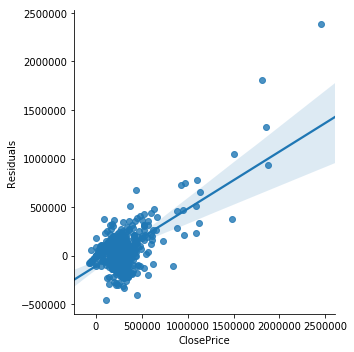

In [28]:
%matplotlib inline

sns.lmplot(x='ClosePrice', y='Residuals', data=df)

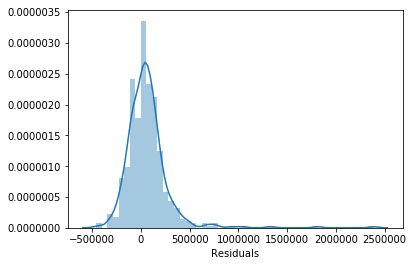

In [29]:
sns.distplot(df['Residuals'])

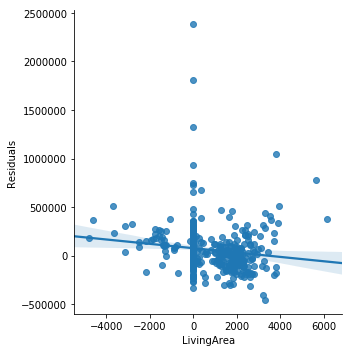

In [30]:
sns.lmplot(x='LivingArea', y='Residuals', data=df)

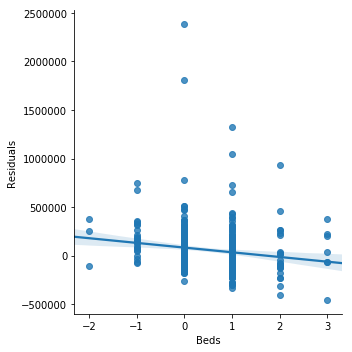

In [31]:
sns.lmplot(x='Beds', y='Residuals', data=df)

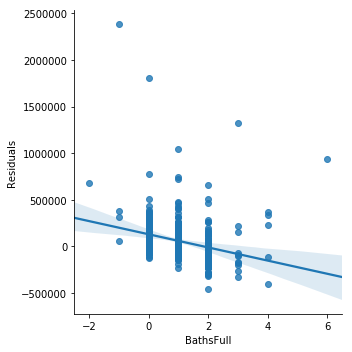

In [32]:
sns.lmplot(x='BathsFull', y='Residuals', data=df)

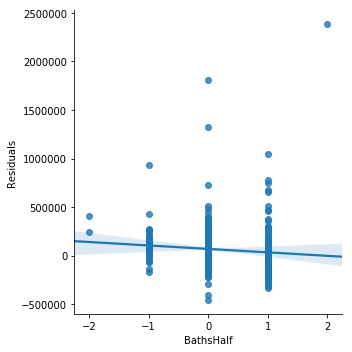

In [33]:
sns.lmplot(x='BathsHalf', y='Residuals', data=df)

In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ClosePrice   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     194.8
Date:                Sat, 07 Apr 2018   Prob (F-statistic):           7.40e-99
Time:                        18:14:17   Log-Likelihood:                -6633.7
No. Observations:                 481   AIC:                         1.328e+04
Df Residuals:                     477   BIC:                         1.329e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
LivingArea    37.0111      8.387      4.413      0.000      20.531      53.491
Beds        4.263e+04   1.57e+04      2.718      0.007    1.18e+04    7.34e+04
BathsFull   1.609e+05   1.08e+04     14.929      0.000     1.4e+05    1.82e+05
BathsHalf   1.111e+05   1.75e+04      6.356      0.000    7.68e+04    1.45e+05
==============================================================================
Omnibus:                      454.757   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20823.223
Skew:                           3.971   Prob(JB):                         0.00
Kurtosis:                      34.240   Cond. No.                     2.48e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model Run #2

Removing outliers that skew the model and performing deeper analysis of independent variables

In [62]:
df = df.loc[df['Residuals'] < 750000]

In [63]:
df

,Ownership,FullStreetAddress,PostalCode,LotSizeArea,LivingArea,ListPrice,ClosePrice,Beds,ListDate,CloseDate,...,"Exterior_Stucco, Siding - Cedar","Exterior_Stucco, Siding - Fiber Cement","Exterior_Stucco, Wood",Exterior_Wood,"Exterior_Wood, Brick, Stone","Exterior_Wood, Hardiplank","Exterior_Wood, Siding - Fiber Cement",y_pred,Residuals,size
CloseDate,,,,,,,,,,,,,,,,,,,,,
2016-05-13,Fee Simple,1005 URELL PL NE,0,0,2750,299000.0,375100.00,0,4/7/16,5/13/16,...,0,0,0,0,0,0,0,3.194085e+05,55691.519205,2
2016-07-01,Fee Simple,1012 BUCHANAN ST NE,0,0,1188,249000.0,249000.00,0,5/13/16,7/1/16,...,0,0,0,0,0,0,0,2.834519e+05,-34451.910204,0
2018-02-16,Fee Simple,1028 SOUTHERN AVE SE,0,0,0,200100.0,215100.00,1,11/30/17,2/16/18,...,0,0,0,0,0,0,0,3.550501e+05,-139950.127617,0
2017-08-23,Fee Simple,1031 46TH ST NE,0,0,-1307,351199.0,267399.00,0,7/5/17,8/23/17,...,0,0,0,0,0,0,0,1.998283e+05,67570.679061,0
2018-03-13,Fee Simple,104 14TH ST NE,0,0,980,239000.0,267000.00,0,2/8/18,3/13/18,...,0,0,0,0,0,0,0,1.195230e+05,147477.027767,0
2016-08-04,Fee Simple,11 ADAMS ST NW,0,0,0,370000.0,370000.00,1,5/19/16,8/4/16,...,0,0,0,0,0,0,0,3.550501e+05,14949.872383,0
2018-01-05,Fee Simple,1100 BARNABY TER SE,0,0,0,130000.0,129000.00,0,9/12/17,1/5/18,...,0,0,0,0,0,0,0,7.028068e+04,58719.320468,0
2017-11-10,Fee Simple,1103 FERN ST NW,0,0,-2805,115000.0,176000.00,-1,9/30/17,11/10/17,...,0,0,0,0,0,0,0,-1.351488e+05,311148.797174,0
2017-04-27,Fee Simple,1109 OATES ST NE,0,0,2144,320100.0,317500.00,0,3/23/17,4/27/17,...,0,0,0,0,0,0,0,2.288168e+05,88683.178735,1


**Description:** Getting rid of residual outliers and rerunning analysis

In [36]:
X = df[['LivingArea', 'Beds', 'BathsFull', 'BathsHalf']]
y = df['ClosePrice']

In [37]:
model = sm.OLS(y,X).fit()

y_pred = model.predict(X)

In [38]:
df['y_pred'] = y_pred
df['Residuals'] = df['ClosePrice'] - df['y_pred']

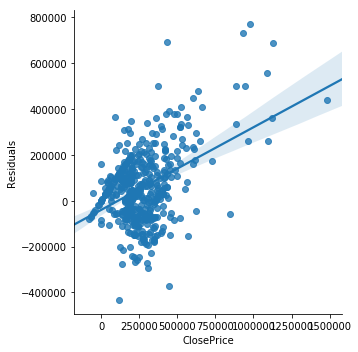

In [42]:
%matplotlib inline

sns.lmplot(x='ClosePrice', y='Residuals', data=df)

In [50]:
liv_area = df.loc[df['LivingArea'] > 1] # getting rid of zero values in living area

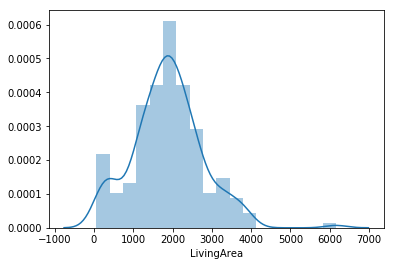

In [52]:
sns.distplot(liv_area['LivingArea']) 

In [54]:
liv_area['LivingArea'].describe()

count     203.000000
mean     1883.078818
std       901.848302
min        66.000000
25%      1337.000000
50%      1858.000000
75%      2351.000000
max      6157.000000
Name: LivingArea, dtype: float64

In [60]:
size = []
for home in df['LivingArea']:
    if home < 1337:
        size.append(0)
    if 1337 <= home <= 2351:
        size.append(1)
    if home >2351:
        size.append(2)

df['size'] = size

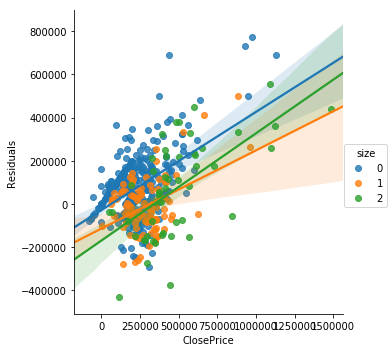

In [61]:
%matplotlib inline

sns.lmplot(x='ClosePrice', y='Residuals', data=df, hue='size')